In [1]:
import tensorflow as tf

print(tf.__version__)


2.11.0


### Retrieve the data from the local datasets folder


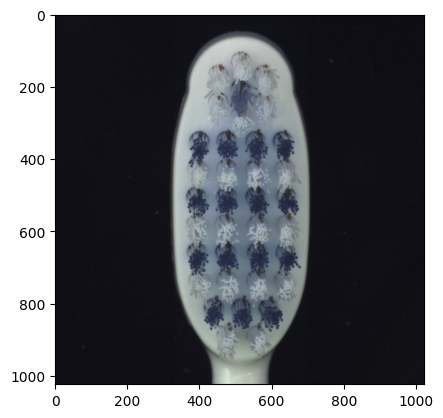

In [3]:
import os

TOOTHBRUSH_DATA_PATH = 'datasets/toothbrush'

TOOTHBRUSH_TRAIN_PATH = os.path.join(TOOTHBRUSH_DATA_PATH, 'train')
TOOTHBRUSH_GOOD_PATH = os.path.join(TOOTHBRUSH_TRAIN_PATH, 'good')

import matplotlib.pyplot as plt

import random

random_img = random.choice(os.listdir(TOOTHBRUSH_GOOD_PATH))

from skimage.io import imread
from skimage.transform import resize

sample_image = imread(os.path.join(TOOTHBRUSH_GOOD_PATH, random_img))
sample_image= sample_image.astype("float32")

plt.imshow(sample_image.astype('uint8'));


In [4]:
sample_image.shape

(1024, 1024, 3)

In [22]:
import numpy as np

def my_init(shape=(5, 5, 3, 3), dtype=None):
    array = np.zeros(shape=shape, dtype="float32")
    array[:, :, 0, 0] = 1 / 25
    array[:, :, 1, 1] = 1 / 25
    array[:, :, 2, 2] = 1 / 25
    return array

# convolutional layer to make the image smaller and extract features
conv = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), input_shape=(None, None, 3), kernel_initializer=my_init)

# spatial pyramid pooling layer
spp = tf.keras.layers.MaxPooling2D(pool_size=(4, 4))

# use the convolutional layer to extract features
img_in = tf.expand_dims(sample_image, axis=0)

img_in.shape

TensorShape([1, 1024, 1024, 3])

In [9]:
img_out = conv(img_in)
img_out = spp(img_out)

img_out.shape

TensorShape([1, 255, 255, 3])

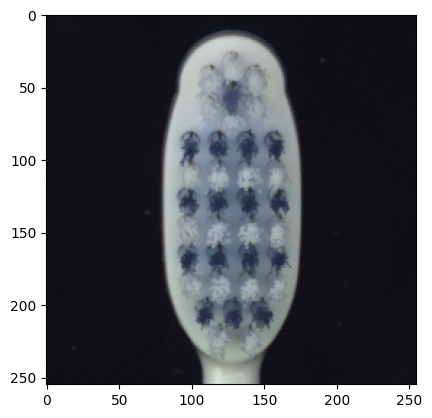

In [10]:
plt.imshow(img_out[0].numpy().astype('uint8'));

### Creating the model

In [27]:
from sspcab import sspcab_layer

class SPP(tf.keras.models.Model):
    def __init__(self, pool_size=(4, 4)):
        super(SPP, self).__init__()
        
        self.conv = tf.keras.layers.Conv2D(filters=3, kernel_size=(5, 5), input_shape=(None, None, 3), kernel_initializer=my_init)
        self.pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)
        

    def call(self, inputs, training=False):
        print(inputs.shape)

        # inputs.shape = (batch_size, height, width, channels)
        # output.shape = (batch_size, height / pool_size[0], width / pool_size[1], channels * pool_size[0] * pool_size[1])
        y = self.conv(inputs)
        y = self.pool(y) 
        
        # currently not working
        # why? because the input shape is not known at compile time (best guess), so the weights cannot be initialized
        y = sspcab_layer(y, name='ssbcap_0', kernel_dim=2, dilation=1, use_act=True, filters=3)
        
        return y

model = SPP()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.predict(img_in)


# reference: https://stackoverflow.com/questions/53804330/image-classification-using-keras-cnn-training-very-slowly
# for image preprocessing and augmentation to increase the number of training samples 
# also for data splitting into training and validation sets and loading the data into the model slowly


(None, 1024, 1024, 3)


TypeError: in user code:

    File "c:\Users\AzqzPC\Desktop\Files\School\CIS490I\PaperReport\venv\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\AzqzPC\Desktop\Files\School\CIS490I\PaperReport\venv\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\AzqzPC\Desktop\Files\School\CIS490I\PaperReport\venv\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\AzqzPC\Desktop\Files\School\CIS490I\PaperReport\venv\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "c:\Users\AzqzPC\Desktop\Files\School\CIS490I\PaperReport\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\AzqzPC\AppData\Local\Temp\__autograph_generated_file05me_rip.py", line 13, in tf__call
        y = ag__.converted_call(ag__.ld(sspcab_layer), (ag__.ld(y),), dict(name='ssbcap_0', kernel_dim=2, dilation=1, use_act=True, filters=3), fscope)

    TypeError: Exception encountered when calling layer 'spp_15' (type SPP).
    
    in user code:
    
        File "C:\Users\AzqzPC\AppData\Local\Temp\ipykernel_67944\1532851122.py", line 19, in call  *
            y = sspcab_layer(y, name='ssbcap_0', kernel_dim=2, dilation=1, use_act=True, filters=3)
    
        TypeError: outer_factory.<locals>.inner_factory.<locals>.tf__sspcab_layer() got an unexpected keyword argument 'use_act'
    
    
    Call arguments received by layer 'spp_15' (type SPP):
      • inputs=tf.Tensor(shape=(None, 1024, 1024, 3), dtype=float32)
      • training=False
